# Event studies
Master thesis of Nikolai Popov, MAE-2025

In [1]:
# Install required libraries
!pip install libpysal esda > /dev/null 2>&1 # hide output
!pip install linearmodels esda > /dev/null 2>&1 # hide output

In [2]:
# Libraries import
import numpy as np # for matrices/vectors
import warnings # to supress warninings
warnings.simplefilter(action='ignore', category=Warning)
from scipy.sparse import identity, kron, csr_matrix, save_npz # for memory efficient sparse matrix
import pandas as pd # dataframes
from libpysal.weights import WSP # to work with sparse inputs
import matplotlib.pyplot as plt # for plots
import statsmodels.formula.api as smf #estimate regression models using R-style formulas
import re # for regular expressions
import geopandas as gpd # to to read shape files
import statsmodels.api as sm # for spatial event-studies
import statsmodels.formula.api as smf # for spatial event-studies
from scipy.sparse import csr_matrix, identity, kron # for spatial event-studies
from scipy.sparse import load_npz # to load W_NT
from linearmodels.panel import PanelOLS # for within estimator
plt.rcParams.update({'font.size': 12}) # setting font of the plot to 14

In [3]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define the path to the file in Google Drive
file_path_df = "/content/drive/My Drive/Coding/balanced_dataset_file_collab.csv"
file_path_gdf = "/content/drive/My Drive/Coding/W_NT_sparse.npz"

# Load CSV with correct encoding and delimiter
balanced_df = pd.read_csv(file_path_df, sep=",", on_bad_lines="skip", low_memory=False)

# scaling to millions of rub
balanced_df['Capital'] = balanced_df['Capital'] / 1e6
balanced_df['Output']  = balanced_df['Output']  / 1e6

loader = np.load(file_path_gdf, allow_pickle=True)
W_NT_sparse = csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                           shape=loader['shape'])

# Optionally, check that it loaded correctly:
print(f"shape of the SWM W_NT:{W_NT_sparse.shape}")

# Show first few rows
balanced_df.head()


shape of the SWM W_NT:(50952, 50952)


,INN,Year,okveds,coord,Capital,Labor,Output,Post_d,Treated_d
0,2435000715,2011,"['01.11', '01.11', '01.41', '01.42', '01.61', ...","56.552422, 93.047783",196.517,527,94.216,0,1
1,2435000715,2012,"['01.11', '01.11', '01.41', '01.42', '01.61', ...","56.552422, 93.047783",256.296,540,157.125,0,1
2,2435000715,2013,"['01.11', '01.11', '01.41', '01.42', '01.61', ...","56.552422, 93.047783",240.583,529,132.336,0,1
3,2435000715,2014,"['01.11', '01.11', '01.41', '01.42', '01.61', ...","56.552422, 93.047783",423.047,546,316.176,1,1
4,2435000715,2015,"['01.11', '01.11', '01.41', '01.42', '01.61', ...","56.552422, 93.047783",378.640,557,364.282,1,1


In [5]:
balanced_df.shape

(50952, 9)

# Event studies

## Standard DID

$$
Y_{it} = \alpha + \sum_{\ell \neq -1} \beta_{\ell} \cdot \text{Treated}_i \cdot \mathbb{1}(\text{event\_time} = \ell) + \text{Capital}_{it} + \delta_i + \delta_t + \varepsilon_{it}
$$

In [6]:
# Step 1: Define treatment year and compute event time
treatment_year = 2014
event_df = balanced_df.copy()
event_df['event_time'] = event_df['Year'] - treatment_year

# Step 2: Drop the baseline year (-1)
event_df = event_df[event_df['event_time'] != -1]

# Step 3: Create event time dummies
event_df = pd.get_dummies(event_df, columns=['event_time'], prefix='event', drop_first=False)

# Step 4: Rename event dummy columns to be Patsy-safe
rename_dict = {}
for col in event_df.columns:
    if re.match(r"event_-?\d+", col):
        new_col = col.replace("event_-", "event_t_minus") if "-" in col else col.replace("event_", "event_t_")
        rename_dict[col] = new_col

event_df = event_df.rename(columns=rename_dict)

# Step 5: Build regression formula with interaction terms
event_dummies = [col for col in event_df.columns if col.startswith("event_t_")]
interaction_terms = [f"Treated_d:{col}" for col in event_dummies]

formula = (
    "Output ~ Capital + Labor  + " +
    " + ".join(interaction_terms) +
    " + C(INN) + C(Year)"
)

# Step 6: Estimate the model with clustered standard errors
model = smf.ols(formula=formula, data=event_df).fit(
    cov_type="cluster", cov_kwds={"groups": event_df["INN"]}
)

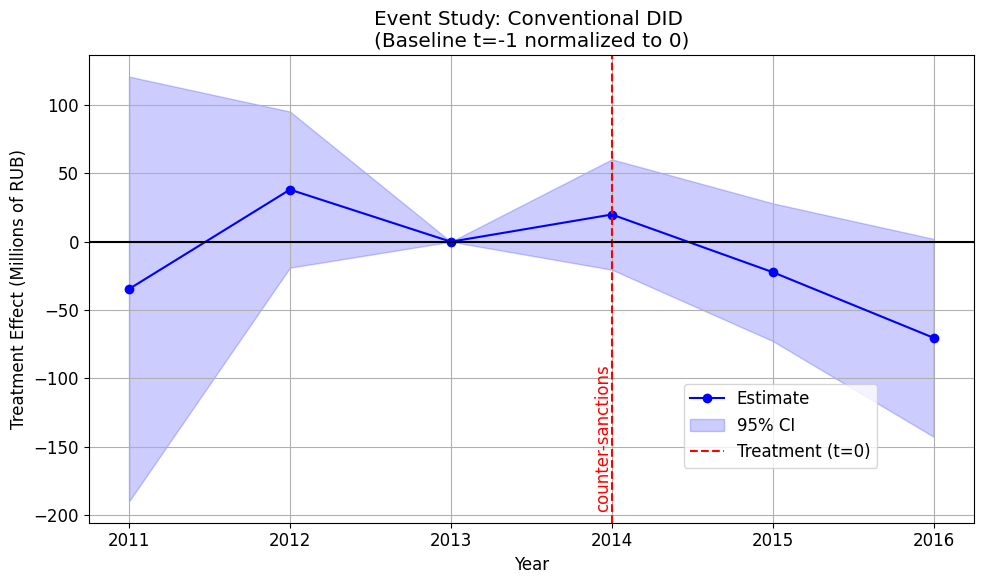

In [7]:
# Assume treatment_year is defined (e.g., 2014)
treatment_year = 2014

# --- Extract coefficients and standard errors (unchanged) ---
event_coefs = model.params[model.params.index.str.startswith("Treated_d:event_t_")]
event_ses = model.bse[model.params.index.str.startswith("Treated_d:event_t_")]

# Parse event time from coefficient names
event_times_raw = event_coefs.index.str.extract(r"event_t_minus(\d+)|event_t_(\d+)")
minus = -event_times_raw[0].fillna(0).astype(int)
plus = event_times_raw[1].fillna(0).astype(int)
event_times = minus + plus

# Build DataFrame with the estimates
plot_df = pd.DataFrame({
    'event_time': event_times.values,
    'coef': event_coefs.values,
    'se': event_ses.values
}).drop_duplicates(subset='event_time')

# Add baseline (t = -1) with coef = 0 and se = 0 if missing
if -1 not in plot_df['event_time'].values:
    baseline = pd.DataFrame({'event_time': [-1], 'coef': [0.0], 'se': [0.0]})
    plot_df = pd.concat([plot_df, baseline], ignore_index=True)

# Sort by event time
plot_df = plot_df.sort_values('event_time')

# --- Convert relative event time to calendar years ---
plot_df['year'] = plot_df['event_time'] + treatment_year

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(plot_df['year'], plot_df['coef'], color='blue', marker='o', label="Estimate")
plt.fill_between(
    plot_df['year'],
    plot_df['coef'] - 1.96 * plot_df['se'],
    plot_df['coef'] + 1.96 * plot_df['se'],
    color='blue', alpha=0.2, label='95% CI'
)

# Draw the vertical line at the treatment year
plt.axvline(x=treatment_year, color='red', linestyle='--', label="Treatment (t=0)")

# Annotate the red vertical line with a vertical label "counter-sanctions"
ymin, ymax = plt.ylim()
plt.text(treatment_year, ymin*0.7, "counter-sanctions", color='red', rotation=90,
         verticalalignment='center', horizontalalignment='right')

plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Treatment Effect (Millions of RUB)")
plt.title("Event Study: Conventional DID \n(Baseline t=-1 normalized to 0)")
plt.legend(loc='lower right', bbox_to_anchor=(0.9, 0.1))
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Coding/event_study.png", dpi=1000, bbox_inches="tight")
plt.show()


## Spatial DID


$$
Y = \beta_0 \boldsymbol{\iota} + X \alpha + \sum_{\ell \neq -1} \beta_{\ell} (D \circ I_\ell) + \sum_{\ell \neq -1} \gamma_{\ell} (\mathbf{W_{NT}} D \circ I_\ell) + \varepsilon
$$

In [8]:
# =============================================================================
# PART 1: Data Preparation & Construction of Direct Interaction Terms
# =============================================================================

# Step 1: Load your balanced panel
df = balanced_df.copy()

# Step 2: Create event_time as Year minus the treatment year.
treatment_year = 2014
df['event_time'] = df['Year'] - treatment_year

# Drop the baseline period t = -1 so that it becomes the omitted/reference category.
df = df[df['event_time'] != -1]

# Step 3: Create event time dummies.
# (Because we dropped t = -1, the remaining dummies correspond to periods relative to that baseline.)
df = pd.get_dummies(df, columns=['event_time'], prefix='event', drop_first=False)
event_cols = [col for col in df.columns if col.startswith('event_')]

# Create the direct interaction terms: Treated_d × each event dummy.
for col in event_cols:
    df[f'{col}_treated'] = df['Treated_d'] * df[col]

# =============================================================================
# PART 2: Spatial Interaction Terms
# =============================================================================

# Step 4: Load the pre-built spatial weights matrix (W_NT_sparse).
# It is assumed that W_NT_sparse was built for the full balanced_df with the same row ordering.
W_NT = W_NT_sparse  # a csr_matrix with dimensions (N_full x N_full)

# Because df is now a subset of balanced_df (due to dropping t = -1),
# subset W_NT to match the rows in df.
# (Assuming the original ordering corresponds to the index of balanced_df)
subset_idx = df.index  # This should be an array of integer positions
W_NT_sub = W_NT[subset_idx, :][:, subset_idx]

# Step 5: Build spatial interaction terms.
# Multiply the subsetted weights matrix by the matrix of direct treatment-event interactions.
spatial_columns = []
X_event = df[[f'{col}_treated' for col in event_cols]].to_numpy()
W_X_event = W_NT_sub.dot(X_event)

# Append each spatial interaction term back to df.
for i, col in enumerate(event_cols):
    new_col = f'spatial_{col}_treated'
    df[new_col] = W_X_event[:, i]
    spatial_columns.append(new_col)



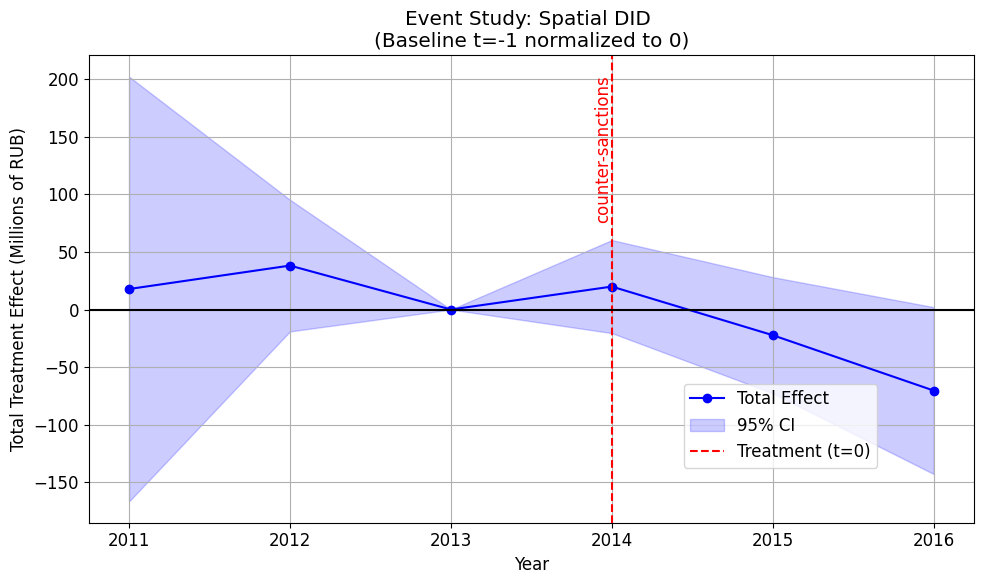

In [9]:
# =============================================================================
# PART 4: Extract and Plot the Event Study Estimates for Spatial DID
# =============================================================================
# The regression includes two sets of dynamic coefficients:
#   1. Direct effects: coefficients on "Treated_d:event_t_X_treated"
#   2. Spatial spillovers: coefficients on "spatial_event_t_X_treated"
# The total effect for each event time is defined as the sum of these two components.
#
# Because we dropped t = -1 from the regression, it is the omitted baseline.
# We add a zero (0) for t = -1 for plotting purposes.

# Assume treatment_year is defined (e.g., 2014)
treatment_year = 2014

# ----- Extract Direct Effects -----
direct_mask = model.params.index.str.startswith("Treated_d:event_")
direct_coefs = model.params[direct_mask]
direct_ses   = model.bse[direct_mask]

# ----- Extract Spatial Effects -----
spatial_mask = model.params.index.str.startswith("spatial_event_")
spatial_coefs = model.params[spatial_mask]
spatial_ses   = model.bse[spatial_mask]

# Function to parse event time from variable names.
def parse_event_time(varname, prefix):
    # Remove the prefix and the _treated suffix.
    core = varname.replace(prefix, "").replace("_treated", "")
    # Remove any trailing bracketed text (e.g., "[False]").
    core = core.split("[")[0]
    # Remove leading "t_" if present.
    if core.startswith("t_"):
        core = core[2:]
    # Convert to integer.
    if "minus" in core:
        return -int(core.replace("minus", ""))
    else:
        return int(core)

# Build dictionaries (keyed by event time) for direct and spatial effects.
direct_dict = {}
for name, coef in direct_coefs.items():
    t_val = parse_event_time(name, "Treated_d:event_")
    direct_dict[t_val] = (coef, direct_ses[name])

spatial_dict = {}
for name, coef in spatial_coefs.items():
    t_val = parse_event_time(name, "spatial_event_")
    spatial_dict[t_val] = (coef, spatial_ses[name])

# Get all event times (from both dictionaries)
all_event_times = sorted(set(list(direct_dict.keys()) + list(spatial_dict.keys())))

# Compute the total effect for each event time as the sum of the direct and spatial coefficients.
# For the standard errors, assuming independence, we combine them as:
#   combined SE = sqrt(se_direct^2 + se_spatial^2)
total_effect = {}
for t in all_event_times:
    direct_coef, direct_se = direct_dict.get(t, (0.0, 0.0))
    spatial_coef, spatial_se = spatial_dict.get(t, (0.0, 0.0))
    total_coef = direct_coef + spatial_coef
    total_se   = np.sqrt(direct_se**2 + spatial_se**2)
    total_effect[t] = (total_coef, total_se)

# Build a DataFrame for plotting.
plot_df = pd.DataFrame({
    'event_time': list(total_effect.keys()),
    'coef': [val[0] for val in total_effect.values()],
    'se': [val[1] for val in total_effect.values()]
})

# Add the baseline (t = -1) with a coefficient of 0 if not already present.
if -1 not in plot_df['event_time'].values:
    baseline = pd.DataFrame({'event_time': [-1], 'coef': [0.0], 'se': [0.0]})
    plot_df = pd.concat([plot_df, baseline], ignore_index=True)

# Sort by event time.
plot_df = plot_df.sort_values('event_time')

# --- Convert relative event time to calendar years ---
plot_df['year'] = plot_df['event_time'] + treatment_year

# ----- Plot the Event Study Estimates -----
plt.figure(figsize=(10, 6))
plt.plot(plot_df['year'], plot_df['coef'], color='blue', marker='o', label="Total Effect")
plt.fill_between(
    plot_df['year'],
    plot_df['coef'] - 1.96 * plot_df['se'],
    plot_df['coef'] + 1.96 * plot_df['se'],
    color='blue', alpha=0.2, label='95% CI'
)

# Draw the vertical line at the treatment year (calendar year)
plt.axvline(x=treatment_year, color='red', linestyle='--', label="Treatment (t=0)")

# Annotate the red vertical line with a vertical label "counter-sanctions".
ymin, ymax = plt.ylim()
ypos = ymin + 0.8*(ymax - ymin)  # Position label 80% above the bottom
plt.text(treatment_year, ypos, "counter-sanctions", color='red', rotation=90,
         verticalalignment='center', horizontalalignment='right')

plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Total Treatment Effect (Millions of RUB)")
plt.title("Event Study: Spatial DID \n(Baseline t=-1 normalized to 0)")
plt.legend(loc='lower right', bbox_to_anchor=(0.9, 0.1))
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Coding/event_study_spatial.png", dpi=1000, bbox_inches="tight")
plt.show()



## Higher order event study

$$
Y = \beta_0 \mathbf{1} + X\alpha + \sum_{\ell \neq -1} \beta_\ell \left( D \circ I_\ell \right) + \sum_{\ell \neq -1} \gamma_\ell \left( \left(\sum_{m=1}^{M} \rho_m \mathbf{W}_{NT}^{m}\right) \left( D \circ I_\ell \right) \right) + \varepsilon,
$$

where:
- \(D\) is the treatment indicator,
- \(I_\ell\) are event time dummies for period \(\ell\) (with \(\ell=-1\) as the omitted baseline),
- \(\mathbf{W}_{NT}^{m}\) denotes the \(m\)th spatial lag matrix,
- \(M\) is the (general) number of spatial lags,
- \(\beta_\ell\) and \(\gamma_\ell\) are the direct and spatial effects, respectively.

In [10]:
# =============================================================================
# PART 1: Data Preparation & Construction of Interaction Terms
# =============================================================================

# Load your balanced panel. (Assume balanced_df is already loaded.)
df = balanced_df.copy()

# Create event_time as Year minus the treatment year (e.g., 2014).
treatment_year = 2014
df['event_time'] = df['Year'] - treatment_year

# Drop the baseline period t = -1 so that it becomes the omitted (reference) category.
df = df[df['event_time'] != -1]

# Create event time dummies.
df = pd.get_dummies(df, columns=['event_time'], prefix='event', drop_first=False)
event_cols = [col for col in df.columns if col.startswith('event_')]

# Create direct interaction terms: Treated_d × each event dummy.
for col in event_cols:
    df[f'{col}_treated'] = df['Treated_d'] * df[col]

# =============================================================================
# PART 2: Spatial Interaction Terms (with M = 3)
# =============================================================================

# It is assumed that W_NT_sparse was built for the full balanced_df with the same row ordering.
W_NT = W_NT_sparse  # a csr_matrix with dimensions (N_full x N_full)

# Because df is now a subset of balanced_df (due to dropping t = -1),
# subset W_NT to match the rows in df.
# (Assuming the original ordering corresponds to the index of balanced_df)
subset_idx = df.index  # This should be an array of integer positions
W_NT_sub = W_NT[subset_idx, :][:, subset_idx]

# Set the maximum order of spatial lags.
M = 3
from scipy.sparse import csr_matrix

# Compute the combined spatial weights matrix: sum of W_NT_sub^1 + W_NT_sub^2 + ... + W_NT_sub^M.
W_total = csr_matrix(W_NT_sub.shape, dtype=np.float64)  # initialize with zeros
W_power = W_NT_sub.copy()  # start with the first-order spatial lag
for m in range(1, M + 1):
    W_total += W_power
    W_power = W_NT_sub.dot(W_power)  # compute next power: W_NT_sub^(m+1)

# Build spatial interaction terms:
spatial_columns = []
# Extract the direct interaction terms (each column corresponds to an event time).
X_event = df[[f'{col}_treated' for col in event_cols]].to_numpy()
# Compute the spatially lagged interaction terms.
W_X_event = W_total.dot(X_event)
for i, col in enumerate(event_cols):
    new_col = f'spatial_{col}_treated'
    df[new_col] = W_X_event[:, i]
    spatial_columns.append(new_col)

# =============================================================================
# PART 3: Regression Estimation (Spatial DID Event Study)
# =============================================================================

# Outcome variable.
y = df['Output']

# Regressors: include a control (e.g. 'Capital' and 'Labor'), the direct DID terms, and the spatial DID terms.
X_vars = ['Capital', 'Labor'] + [f'{col}_treated' for col in event_cols] + spatial_columns
X = df[X_vars]
X = sm.add_constant(X)

# Optionally add firm and year fixed effects via dummy variables.
X = pd.concat([
    X,
    pd.get_dummies(df['INN'], prefix='firm', drop_first=True),
    pd.get_dummies(df['Year'], prefix='year', drop_first=True)
], axis=1)

# Convert all columns to float64 to avoid dtype issues.
X = X.astype(np.float64)
y = y.astype(np.float64)

# Estimate the OLS regression with clustered standard errors (clustered by INN).
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': df['INN']})
# print(model.summary())

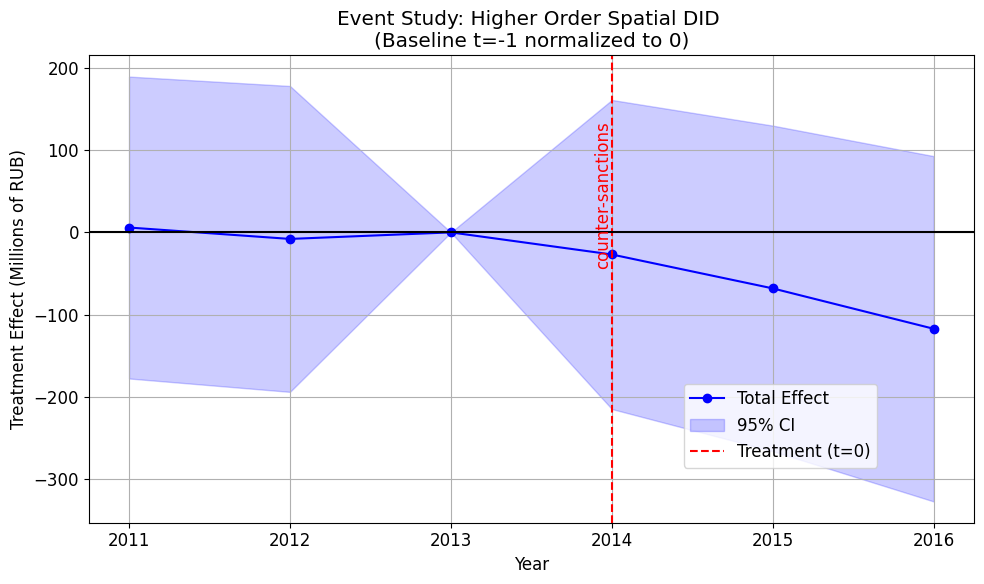

In [11]:
# =============================================================================
# PART 4: Extract and Plot the Event Study Coefficients
# =============================================================================

# Here we extract coefficients for the event study from:
#   (a) Direct effects: variables named "event_XXX_treated"
#   (b) Spatial effects: variables named "spatial_event_XXX_treated"

# Assume treatment_year is defined (e.g., 2014)
treatment_year = 2014

# ----- Extract direct event coefficients and standard errors.
direct_coef_mask = model.params.index.str.startswith("event_")
direct_coefs = model.params[direct_coef_mask]
direct_ses   = model.bse[direct_coef_mask]

# Extract spatial event coefficients and standard errors.
spatial_coef_mask = model.params.index.str.startswith("spatial_event_")
spatial_coefs = model.params[spatial_coef_mask]
spatial_ses   = model.bse[spatial_coef_mask]

# Helper function to parse event time from variable names.
def parse_event_time(varname, prefix):
    # Remove the prefix and the trailing "_treated"
    core = varname.replace(prefix, "").replace("_treated", "")
    try:
        # For names like "event_-3_treated", core should be "-3"
        return int(core)
    except ValueError:
        # If the naming convention uses "minus" (e.g., "event_minus3_treated")
        if "minus" in core:
            return -int(core.replace("minus", ""))
        else:
            raise ValueError(f"Could not parse event time from variable name: {varname}")

# Build dictionaries keyed by event time.
direct_dict = {}
for name, coef in direct_coefs.items():
    t_val = parse_event_time(name, "event_")
    direct_dict[t_val] = (coef, direct_ses[name])

spatial_dict = {}
for name, coef in spatial_coefs.items():
    t_val = parse_event_time(name, "spatial_event_")
    spatial_dict[t_val] = (coef, spatial_ses[name])

# All event times present.
all_event_times = sorted(set(list(direct_dict.keys()) + list(spatial_dict.keys())))

# Compute total effect for each event time (direct + spatial).
total_effect = {}
for t in all_event_times:
    d_coef, d_se = direct_dict.get(t, (0.0, 0.0))
    s_coef, s_se = spatial_dict.get(t, (0.0, 0.0))
    total_coef = d_coef + s_coef
    # Combine standard errors assuming independence:
    total_se = np.sqrt(d_se**2 + s_se**2)
    total_effect[t] = (total_coef, total_se)

# Build a DataFrame for plotting.
plot_df = pd.DataFrame({
    'event_time': list(total_effect.keys()),
    'coef': [val[0] for val in total_effect.values()],
    'se': [val[1] for val in total_effect.values()]
})

# Optionally, add a baseline at t = -1 with a coefficient of 0 if not present.
if -1 not in plot_df['event_time'].values:
    baseline = pd.DataFrame({'event_time': [-1], 'coef': [0.0], 'se': [0.0]})
    plot_df = pd.concat([plot_df, baseline], ignore_index=True)

plot_df = plot_df.sort_values('event_time')

# --- Convert relative event time to calendar years ---
plot_df['year'] = plot_df['event_time'] + treatment_year

# ----- Plot the Event Study Results -----
plt.figure(figsize=(10, 6))
plt.plot(plot_df['year'], plot_df['coef'], color='blue', marker='o', label="Total Effect")
plt.fill_between(
    plot_df['year'],
    plot_df['coef'] - 1.96 * plot_df['se'],
    plot_df['coef'] + 1.96 * plot_df['se'],
    color='blue', alpha=0.2, label='95% CI'
)

# Draw the vertical line at the treatment year (calendar year)
plt.axvline(x=treatment_year, color='red', linestyle='--', label="Treatment (t=0)")

# Annotate the red vertical line with a vertical label "counter-sanctions"
ymin, ymax = plt.ylim()
ypos = ymin + 0.7*(ymax - ymin)  # Adjust position as needed
plt.text(treatment_year, ypos, "counter-sanctions", color='red', rotation=90,
         verticalalignment='center', horizontalalignment='right')

plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Treatment Effect (Millions of RUB)")
plt.title("Event Study: Higher Order Spatial DID \n(Baseline t=-1 normalized to 0)")
plt.legend(loc='lower right', bbox_to_anchor=(0.9, 0.1))
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Coding/event_study_spatial_highO.png", dpi=1000, bbox_inches="tight")
plt.show()


# Models

### DID
$$
\mathbf{Y} =
\beta_0 \underbrace{\mathbf{\iota}}_{NT \times 1}
+ \underbrace{\mathbf{X}}_{NT \times K} \underbrace{\alpha}_{K \times 1}
+ \beta_1 \underbrace{\mathbf{D}}_{NT \times 1}
+ \beta_2 \underbrace{\mathbf{T}}_{NT \times 1}
+ \beta_3 \underbrace{(\mathbf{D} \circ \mathbf{T})}_{NT \times 1}
+ \underbrace{\boldsymbol{\varepsilon}}_{NT \times 1}
$$

In [12]:
# -------------------------------
# Data Preparation for DiD
# -------------------------------
# Make a copy of your balanced panel
df = balanced_df.copy()

# Create log-transformed variables for Output, Capital, and Labor.
df['ln_Output'] = np.log(df['Output'])
df['ln_Capital'] = np.log(df['Capital'])
df['ln_Labor'] = np.log(df['Labor'])  # Added labor

# In your specification, use:
# - D (treatment indicator) from Treated_d
# - T (time indicator) from Post_d
df['D'] = df['Treated_d']
df['T'] = df['Post_d']

# (Optional) Check the data to ensure you have both pre- and post-treatment observations.
print("Unique Years:", df['Year'].unique())
print("Unique values for T (post dummy):", df['T'].unique())
print("Unique values for D (treatment dummy):", df['D'].unique())

# -------------------------------
# DiD Regression
# -------------------------------
# The DID formula is now:
# ln_Output = β0 + α1 ln_Capital + α2 ln_Labor + β1 D + β2 T + β3 (D*T) + error
# The formula "D * T" expands to "D + T + D:T".
formula = "ln_Output ~ ln_Capital + ln_Labor + D * T"

# Estimate the model using OLS with clustered standard errors by INN.
did_model = smf.ols(formula=formula, data=df).fit(cov_type='cluster', cov_kwds={'groups': df['INN']})

# Display the regression summary.
print(did_model.summary())

Unique Years: [2011 2012 2013 2014 2015 2016]
Unique values for T (post dummy): [0 1]
Unique values for D (treatment dummy): [1 0]
                            OLS Regression Results                            
Dep. Variable:              ln_Output   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     4174.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        08:47:12   Log-Likelihood:                -84903.
No. Observations:               50952   AIC:                         1.698e+05
Df Residuals:                   50946   BIC:                         1.699e+05
Df Model:                           5                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]


With FE:

$$
\ln(y_{it}) = \beta_0 + \alpha_1 \ln(C_{it}) + \beta_3 (D_i \times T_t) + FE_{\mathrm{i}} + FE_{\mathrm{t}} + \varepsilon_{it}
$$

In [13]:
# --- Data Preparation ---
df_did = balanced_df.copy()

# Create log-transformed variables for Output, Capital, and Labor.
df_did['ln_Output'] = np.log(df_did['Output'])
df_did['ln_Capital'] = np.log(df_did['Capital'])
df_did['ln_Labor'] = np.log(df_did['Labor'])  # Added labor

# Define treatment indicator D and time dummy T.
df_did['D'] = df_did['Treated_d']
df_did['T'] = df_did['Post_d']

# Create the interaction term.
df_did['D_T'] = df_did['D'] * df_did['T']

# Set a MultiIndex for panel estimation (entity: INN, time: Year).
df_did = df_did.set_index(['INN', 'Year'])

# Prepare exogenous variables.
# Since D and T are absorbed by the fixed effects (if time-invariant or fully collinear with time effects),
# we include ln_Capital, ln_Labor, and the interaction term D_T.
exog = sm.add_constant(df_did[['ln_Capital', 'ln_Labor', 'D_T']])
endog = df_did['ln_Output']

# --- Model Estimation using the Within Estimator ---
# Estimate a PanelOLS model with entity (and time) fixed effects.
# This "within" estimator differences out the individual (INN) effects (and time effects, if time_effects=True).
mod_within = PanelOLS(endog, exog, entity_effects=True, time_effects=True)
did_fe_model = mod_within.fit(cov_type='clustered', cluster_entity=True)

# Display the summary. Notice that FE coefficients are not reported.
print(did_fe_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_Output   R-squared:                        0.2728
Estimator:                   PanelOLS   R-squared (Between):              0.5617
No. Observations:               50952   R-squared (Within):               0.3378
Date:                Tue, Apr 01 2025   R-squared (Overall):              0.5481
Time:                        08:47:12   Log-likelihood                -3.032e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5308.8
Entities:                        8492   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                 F(3,42452)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             354.15
                            

In [14]:
# -------------------------------
# Helper Functions
# -------------------------------
def stars_from_p(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

def format_coef(model, var):
    # Try the variable name as given.
    if var in model.params:
        coef = model.params[var]
        se = model.bse[var] if hasattr(model, 'bse') else model.std_errors[var]
        p = model.pvalues[var]
    else:
        # If not found, try replacing ":" with "_" (e.g., "D:T" -> "D_T")
        alt_var = var.replace(":", "_")
        if alt_var in model.params:
            coef = model.params[alt_var]
            se = model.bse[alt_var] if hasattr(model, 'bse') else model.std_errors[alt_var]
            p = model.pvalues[alt_var]
        else:
            return ""
    star_str = stars_from_p(p)
    return f"{coef:.3f}{star_str}\n({se:.3f})"

# -------------------------------
# Build Formatted DID Results Using the Within Estimator for FE
# -------------------------------
# Define the key variables to display. Now includes ln_Labor.
coef_vars = ["ln_Capital", "ln_Labor", "D", "T", "D:T"]

# Directly create the final formatted results table as results_did.
results_did = pd.DataFrame({var: {"DID": format_coef(did_model, var),
                                  "DID (FE)": format_coef(did_fe_model, var)}
                             for var in coef_vars}).T

# Append summary rows for N and FE (using the actual values from the models).
results_did.loc["N"] = [f"{int(did_model.nobs)}", f"{int(did_fe_model.nobs)}"]
results_did.loc["FE"] = ["No", "Yes"]

results_did

,DID,DID (FE)
ln_Capital,0.405***\n(0.009),0.055***\n(0.005)
ln_Labor,1.017***\n(0.016),1.107***\n(0.038)
D,-0.241***\n(0.034),
T,-0.073***\n(0.016),
D:T,0.035**\n(0.018),0.067***\n(0.018)
N,50952,50952
FE,No,Yes


### SDID

$$
Y =
\beta_0 \iota
+ \mathbf{X} \alpha
+ \beta_1 \mathbf{D}
+ \beta_2 \mathbf{T}
+ \beta_3 (\mathbf{D} \circ \mathbf{T})
+ \beta_4 (\underbrace{\mathbf{W_{NT}}}_{NT \times NT}\mathbf{D} \circ \mathbf{T})
+ \boldsymbol{\varepsilon}
$$

With FE:

$$
Y =
\beta_0 \mathbf{\iota}
+ \mathbf{X} \alpha
+ \beta_3 (\mathbf{D} \circ \mathbf{T})
+ \beta_4 (\underbrace{\mathbf{W_{NT}}}_{NT \times NT}\mathbf{D} \circ \mathbf{T})
+ \boldsymbol{\varepsilon} + FE_{\mathrm{t}} + FE_{\mathrm{i}} + \varepsilon_{it}
$$

In [15]:
# ================================
# PART 1: Data Preparation for Spatial DID
# ================================
# Use the full balanced panel and sort it by index (or another appropriate ordering)
df_spatial = balanced_df.copy().sort_index()

# (Optional) Check dimensions to confirm they match.
print("df_spatial shape:", df_spatial.shape)
print("W_NT shape:", W_NT.shape)

# Use the entire spatial weights matrix directly.
# Create log-transformed variables.
df_spatial['ln_Output'] = np.log(df_spatial['Output'])
df_spatial['ln_Capital'] = np.log(df_spatial['Capital'])
df_spatial['ln_Labor'] = np.log(df_spatial['Labor'])  # Added labor

# Define treatment indicator D and time dummy T.
df_spatial['D'] = df_spatial['Treated_d']
df_spatial['T'] = df_spatial['Post_d']

# Compute the spatial lag of D and then the spatial interaction term.
# This works only if the number of rows in df_spatial equals the dimensions of W_NT.
df_spatial['W_D'] = W_NT.dot(df_spatial['D'].values)
df_spatial['W_D_T'] = df_spatial['W_D'] * df_spatial['T']

# ================================
# PART 2: Model Estimation for Spatial DID
# ================================
# Model 1: Non-FE Spatial DID (using smf.ols)
formula_spatial1 = "ln_Output ~ ln_Capital + ln_Labor + D + T + D:T + W_D_T"
sdid_model = smf.ols(formula=formula_spatial1, data=df_spatial).fit(
    cov_type='cluster', cov_kwds={'groups': df_spatial['INN']})
print(sdid_model.summary())



df_spatial shape: (50952, 9)
W_NT shape: (50952, 50952)
                            OLS Regression Results                            
Dep. Variable:              ln_Output   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     3479.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        08:47:12   Log-Likelihood:                -84900.
No. Observations:               50952   AIC:                         1.698e+05
Df Residuals:                   50945   BIC:                         1.699e+05
Df Model:                           6                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [16]:
# Model 2: FE Spatial DID using PanelOLS (Within Estimator)
# According to your formula, when using FE we exclude the main effects for D and T.
# So the FE specification is:
# ln_Output = β₀ + α₁ ln_Capital + α₂ ln_Labor + β₃ (D×T) + β₄ (W_NT * D×T) + FE_i + FE_t + error.
# First, create the interaction term D×T.
df_spatial['D_T'] = df_spatial['D'] * df_spatial['T']

# Set the panel index.
df_panel = df_spatial.set_index(['INN', 'Year'])

# For the FE model, our regressors are: constant, ln_Capital, ln_Labor, D_T, and W_D_T.
exog_vars = ['ln_Capital', 'ln_Labor', 'D_T', 'W_D_T']
exog = sm.add_constant(df_panel[exog_vars])
endog = df_panel['ln_Output']

within_model = PanelOLS(endog, exog, entity_effects=True, time_effects=True)
sdid_fe_model = within_model.fit(cov_type='clustered', cluster_entity=True)

print(sdid_fe_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_Output   R-squared:                        0.2728
Estimator:                   PanelOLS   R-squared (Between):              0.5617
No. Observations:               50952   R-squared (Within):               0.3381
Date:                Tue, Apr 01 2025   R-squared (Overall):              0.5482
Time:                        08:47:12   Log-likelihood                -3.032e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3981.8
Entities:                        8492   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                 F(4,42451)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             265.61
                            

In [17]:
# ================================
# PART 3: Create a Formatted Summary Table for Spatial DID
# ================================
# We wish to compare the following key variables:
# For the non-FE model: ln_Capital, ln_Labor, D, T, D:T, W_D_T.
# For the FE model: ln_Capital, ln_Labor, D:T (reported as D_T), and W_D_T (D and T are absorbed).
coef_vars = ["ln_Capital", "ln_Labor", "D", "T", "D:T", "W_D_T"]

def stars_from_p(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

def format_coef(model, var):
    # For the non-FE model (smf.ols), variable names are as given.
    if var in model.params:
        coef = model.params[var]
        se = model.bse[var]
        p = model.pvalues[var]
        return f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})"
    else:
        return ""

def format_coef_fe(model, var):
    # For the FE model via PanelOLS, note that the interaction D:T is reported as "D_T".
    if var in ['D', 'T']:
        # These are absorbed by FE, so we return blank.
        return ""
    if var == "D:T" and "D_T" in model.params:
        var = "D_T"
    if var in model.params:
        coef = model.params[var]
        se = model.std_errors[var]
        p = model.pvalues[var]
        return f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})"
    else:
        return ""

results_data = {}
for var in coef_vars:
    results_data[var] = {
        "Spatial DID": format_coef(sdid_model, var),
        "Spatial DID (FE)": format_coef_fe(sdid_fe_model, var)
    }
results_sdid = pd.DataFrame(results_data).T  # Final table named results_sdid

# Append summary rows for sample size (N) and FE indicator.
results_sdid.loc["N"] = [f"{int(sdid_model.nobs)}", f"{int(sdid_fe_model.nobs)}"]
results_sdid.loc["FE"] = ["No", "Yes"]

# Move the summary rows "N" and "FE" to the bottom.
new_order = [row for row in results_sdid.index if row not in ["N", "FE"]] + ["N", "FE"]
results_sdid = results_sdid.reindex(new_order)

results_sdid

,Spatial DID,Spatial DID (FE)
ln_Capital,0.405***\n(0.009),0.055***\n(0.005)
ln_Labor,1.017***\n(0.016),1.107***\n(0.038)
D,-0.241***\n(0.034),
T,-0.104***\n(0.024),
D:T,0.034*\n(0.018),0.067***\n(0.018)
W_D_T,0.000*\n(0.000),0.000\n(0.000)
N,50952,50952
FE,No,Yes


### Higher order - unrestricted

$$
\mathbf{Y} =
\beta_0 \mathbf{\iota}
+ \mathbf{X} \alpha
+ \beta_1 \mathbf{D}
+ \beta_2 \mathbf{T}
+ \beta_3 (\mathbf{D} \circ \mathbf{T})
+ \beta_4 \left( \sum\limits_{m=1}^{M}\rho_{m}\mathbf{W}_{NT}^{m}\right)\mathbf{D} \circ \mathbf{T}
+ \boldsymbol{\varepsilon}
$$

#### Choice of the optimal order

In [18]:
# ================================
# PART 0: Define Maximum Order H
# ================================
H = 10  # Maximum order of spatial lags to consider

# ================================
# PART 1: Data Preparation & Variable Construction
# ================================
# Assume gdf is your geographic dataset (used to construct W_NT) with an 'INN' column.
# Use the full balanced panel and sort it by index (or another appropriate ordering)
df_spatial = balanced_df.copy().sort_index()

# Create log-transformed variables for Output, Capital, and Labor.
df_spatial['ln_Output'] = np.log(df_spatial['Output'])
df_spatial['ln_Capital'] = np.log(df_spatial['Capital'])
df_spatial['ln_Labor'] = np.log(df_spatial['Labor'])  # Added labor

# Define treatment indicator D and time dummy T.
df_spatial['D'] = df_spatial['Treated_d']
df_spatial['T'] = df_spatial['Post_d']

# ================================
# PART 2: Compute Spatial Interaction Terms for m = 1,...,H
# ================================
# We will create new columns: for each order m, define W_D{m}_T = (W_NT^m * D) * T.
# Start by computing the first order.
W_power = W_NT.copy()  # This is W_NT^1.
for m in range(1, H+1):
    col_name = f'W_D{m}_T'
    df_spatial[col_name] = W_power.dot(df_spatial['D'].values) * df_spatial['T']
    # Update the power if not yet reached maximum order.
    if m < H:
        W_power = W_NT.dot(W_power)

# ================================
# PART 3: Estimate Models for M = 1,...,H and Select Optimal M by BIC
# ================================
bic_values = {}
models = {}
for M in range(1, H+1):
    # Base formula now includes ln_Capital and ln_Labor along with D, T, and D:T.
    formula = "ln_Output ~ ln_Capital + ln_Labor + D + T + D:T"
    # Append spatial interaction terms for orders 1 to M.
    for m in range(1, M+1):
        formula += f" + W_D{m}_T"
    model_M = smf.ols(formula=formula, data=df_spatial).fit(
        cov_type='cluster', cov_kwds={'groups': df_spatial['INN']})
    bic_values[M] = model_M.bic
    models[M] = model_M
    print(f"M = {M}, BIC = {model_M.bic:.3f}")

optimal_M = min(bic_values, key=bic_values.get)
print("\nOptimal M =", optimal_M, "with BIC =", bic_values[optimal_M])
optimal_model = models[optimal_M]

# ================================
# PART 4: Estimate Corresponding Model with Fixed Effects
# ================================
# For the FE model, include ln_Capital and ln_Labor along with D, T, and D:T,
# and then add spatial interaction terms for orders 1 to optimal_M.
formula_fe = "ln_Output ~ ln_Capital + ln_Labor + D + T + D:T"
for m in range(1, optimal_M+1):
    formula_fe += f" + W_D{m}_T"
formula_fe += " + C(INN) + C(Year)"
model_fe = smf.ols(formula=formula_fe, data=df_spatial).fit(
    cov_type='cluster', cov_kwds={'groups': df_spatial['INN']})

# ================================
# PART 5: Build a LaTeX Summary Table for the Optimal Models
# ================================
# Define helper functions for formatting coefficients.
def stars_from_p(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

def format_coef(model, var):
    coef = model.params[var]
    se = model.bse[var]
    p = model.pvalues[var]
    star_str = stars_from_p(p)
    return f"{coef:.3f}{star_str}\n({se:.3f})"

# List key variables to display.
# We display ln_Capital, ln_Labor, D, T, D:T, and the spatial interaction terms up to the optimal order.
coef_vars_opt = ["ln_Capital", "ln_Labor", "D", "T", "D:T"] + [f"W_D{m}_T" for m in range(1, optimal_M+1)]

results_data = {}
for var in coef_vars_opt:
    results_data[var] = {
        "Spatial DID (M optimal)": format_coef(optimal_model, var),
        "Spatial DID (FE, M optimal)": format_coef(model_fe, var)
    }
results_opt_H = pd.DataFrame(results_data).T  # Final table named results_opt_H
results_opt_H.loc["N"] = [f"{int(optimal_model.nobs)}", f"{int(model_fe.nobs)}"]
results_opt_H.loc["FE"] = ["No", "Yes"]

# ================================
# PART 6: Convert the Final DataFrame to LaTeX
# ================================
latex_table_opt = results_opt_H.to_latex(escape=False, float_format="%.3f",
                                      caption=f"Optimal Extended Spatial DID Results (M={optimal_M})",
                                      label="tab:optimal_spatial_did")
print(latex_table_opt)

M = 1, BIC = 169876.856
M = 2, BIC = 169886.085
M = 3, BIC = 169896.515
M = 4, BIC = 169906.706
M = 5, BIC = 173633.422
M = 6, BIC = 277718.837
M = 7, BIC = 280747.056
M = 8, BIC = 281872.816
M = 9, BIC = 283400.738
M = 10, BIC = 284992.643

Optimal M = 1 with BIC = 169876.85636822644
\begin{table}
\caption{Optimal Extended Spatial DID Results (M=1)}
\label{tab:optimal_spatial_did}
\begin{tabular}{lll}
\toprule
 & Spatial DID (M optimal) & Spatial DID (FE, M optimal) \\
\midrule
ln_Capital & 0.405***
(0.009) & 0.055***
(0.005) \\
ln_Labor & 1.017***
(0.016) & 1.107***
(0.038) \\
D & -0.241***
(0.034) & 1.012***
(0.064) \\
T & -0.104***
(0.024) & 0.013
(0.016) \\
D:T & 0.034*
(0.018) & 0.067***
(0.018) \\
W_D1_T & 0.000*
(0.000) & 0.000
(0.000) \\
N & 50952 & 50952 \\
FE & No & Yes \\
\bottomrule
\end{tabular}
\end{table}



#### The optimal model

In [19]:
# ================================
# PART 0: Define Maximum Order Parameter
# ================================
# H_optimal = int(optimal_M) # Maximum order of spatial lags to consider
H_optimal = 3
# ================================
# PART 1: Data Preparation & Variable Construction for Extended Spatial DID (H_optimal) - REST
# ================================
df_spatial_rest = balanced_df.copy().sort_index()

# Create log-transformed variables for Output, Capital, and Labor.
df_spatial_rest['ln_Output'] = np.log(df_spatial_rest['Output'])
df_spatial_rest['ln_Capital'] = np.log(df_spatial_rest['Capital'])
df_spatial_rest['ln_Labor'] = np.log(df_spatial_rest['Labor'])  # Added labor

# Define treatment indicator D and time dummy T.
df_spatial_rest['D'] = df_spatial_rest['Treated_d']
df_spatial_rest['T'] = df_spatial_rest['Post_d']
# Create the interaction term D*T.
df_spatial_rest['D_T'] = df_spatial_rest['D'] * df_spatial_rest['T']

# ================================
# PART 2: Compute Spatial Interaction Terms for m = 1,...,H_optimal
# ================================
# For each order m, compute: W_D{m}_T = (W_NT^m * D) * T.
# For m=1, we name the column "W_D_T" (not "W_D1_T").
W_power = W_NT.copy()  # This is W_NT^1.
for m in range(1, H_optimal+1):
    if m == 1:
        col_name = "W_D_T"
    else:
        col_name = f"W_D{m}_T"
    df_spatial_rest[col_name] = W_power.dot(df_spatial_rest['D'].values) * df_spatial_rest['T']
    if m < H_optimal:
        W_power = W_NT.dot(W_power)

# ================================
# PART 3: Model Estimation for Extended Spatial DID (H_optimal) - REST
# ================================
# 3A. Non-FE Extended Spatial DID Model via OLS.
# Include ln_Capital, ln_Labor, D, T, and D:T.
formula_extended1 = "ln_Output ~ ln_Capital + ln_Labor + D + T + D:T"
for m in range(1, H_optimal+1):
    if m == 1:
        formula_extended1 += " + W_D_T"
    else:
        formula_extended1 += f" + W_D{m}_T"
hdid_model = smf.ols(formula=formula_extended1, data=df_spatial_rest).fit(
    cov_type='cluster', cov_kwds={'groups': df_spatial_rest['INN']})

hdid_model.summary()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ln_Output   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     2823.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:41:20   Log-Likelihood:                -84899.
No. Observations:               50952   AIC:                         1.698e+05
Df Residuals:                   50943   BIC:                         1.699e+05
Df Model:                           8                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5102      0.068    -22.220      0.000      -1.643      -1.377
ln_Capital     0.4054      0.009     45.924      0.000       0.388       0.423
ln_Labor       1.0169      0.016     62.105      0.000       0.985       1.049
D             -0.2408      0.034     -7.140      0.000      -0.307      -0.175
T             -0.1140      0.037     -3.081      0.002      -0.187      -0.041
D:T            0.0340      0.018      1.923      0.054      -0.001       0.069
W_D_T       4.658e-05      0.000      0.121      0.904      -0.001       0.001
W_D2_T      3.045e-07   8.94e-07      0.341      0.733   -1.45e-06    2.06e-06
W_D3_T     -2.731e-10   5.54e-10     -0.493      0.622   -1.36e-09    8.13e-10
==============================================================================
Omnibus:                     4694.992   Durbin-Watson:                   0.550
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20774.889
Skew:                          -0.364   Prob(JB):                         0.00
Kurtosis:                       6.043   Cond. No.                     2.94e+09
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 2.94e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# 3B. FE Extended Spatial DID Model using PanelOLS (Within Estimator).
# For the FE model, we drop the main effects for D and T (absorbed by FE) and include only ln_Capital, ln_Labor, D_T, and the spatial interaction terms.
df_panel = df_spatial_rest.set_index(['INN', 'Year'])
exog_vars = ['ln_Capital', 'ln_Labor', 'D_T'] + [f"W_D_T"] + [f"W_D{m}_T" for m in range(2, H_optimal+1)]
exog = sm.add_constant(df_panel[exog_vars])
endog = df_panel['ln_Output']
within_model = PanelOLS(endog, exog, entity_effects=True, time_effects=True)
hdid_fe_model = within_model.fit(cov_type='clustered', cluster_entity=True)

print(hdid_fe_model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              ln_Output   R-squared:                        0.2729
Estimator:                   PanelOLS   R-squared (Between):              0.5617
No. Observations:               50952   R-squared (Within):               0.3379
Date:                Tue, Apr 01 2025   R-squared (Overall):              0.5482
Time:                        09:41:20   Log-likelihood                -3.032e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2655.0
Entities:                        8492   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                 F(6,42449)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             177.94
                            

In [21]:
# ================================
# PART 4: Create a Summary Table (Key Coefficients Only) - REST
# ================================
# For the non-FE model, we display: ln_Capital, ln_Labor, D, T, D:T, and spatial terms.
# For the FE model, we display: ln_Capital, ln_Labor, D_T (the interaction), and spatial terms.
# We'll build a table that uses the following ordered row labels:
ordered_vars = ["ln_Capital", "ln_Labor", "D", "T", "D:T"] + [f"W_D_T"] + [f"W_D{m}_T" for m in range(2, H_optimal+1)]

def stars_from_p(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

def format_coef(model, var):
    # For the FE model, if "D:T" is not present, try "D_T".
    if var not in model.params:
        alt_var = var.replace(":", "_")
        if alt_var in model.params:
            var = alt_var
        else:
            return ""
    coef = model.params[var]
    se = model.bse[var] if hasattr(model, 'bse') else model.std_errors[var]
    p = model.pvalues[var]
    return f"{coef:.3f}{stars_from_p(p)}\n({se:.3f})"

results_data = {}
for var in ordered_vars:
    results_data[var] = {
        "Higher Order": format_coef(hdid_model, var),
        "Higher Order (FE)": format_coef(hdid_fe_model, var)
    }
results_sdidH = pd.DataFrame(results_data).T  # Final table

# Append summary rows for sample size (N) and FE indicator.
results_sdidH.loc["N"] = [f"{int(hdid_model.nobs)}", f"{int(hdid_fe_model.nobs)}"]
results_sdidH.loc["FE"] = ["No", "Yes"]

# Move the summary rows "N" and "FE" to the bottom.
new_order = [r for r in results_sdidH.index if r not in ["N", "FE"]] + ["N", "FE"]
results_sdidH = results_sdidH.reindex(new_order)
results_sdidH

,Higher Order,Higher Order (FE)
ln_Capital,0.405***\n(0.009),0.055***\n(0.005)
ln_Labor,1.017***\n(0.016),1.107***\n(0.038)
D,-0.241***\n(0.034),
T,-0.114***\n(0.037),
D:T,0.034*\n(0.018),0.067***\n(0.018)
W_D_T,0.000\n(0.000),-0.000\n(0.000)
W_D2_T,0.000\n(0.000),0.000\n(0.000)
W_D3_T,-0.000\n(0.000),-0.000\n(0.000)
N,50952,50952
FE,No,Yes


### Final table

In [30]:
# -------------------------------
# 4. Merge the Three Tables into One Final DataFrame
# -------------------------------
combined_df = pd.concat([results_df_did, results_df_sdid, results_df_ext],
                        axis=1, keys=["DID", "SDID", "Higher Order"])

# Flatten the MultiIndex columns by taking only the second level.
combined_df.columns = combined_df.columns.get_level_values(1)

# Move the "N" and "FE" rows to the bottom.
new_order = [row for row in combined_df.index if row not in ["N", "FE"]] + ["N", "FE"]
combined_df = combined_df.reindex(new_order)

# Replace all NaN values with an empty string.
combined_df = combined_df.fillna("")

# -------------------------------
# 5. Convert the Final DataFrame to LaTeX
# -------------------------------
latex_combined = combined_df.to_latex(escape=False,
                                      caption="Combined DID, Spatial DID, and Higher Order Spatial DID Results",
                                      label="tab:combined_results")
print(latex_combined)

# Save the LaTeX table to a file in Colab.
with open("combined_results_table.tex", "w") as f:
    f.write(latex_combined)

\begin{table}
\caption{Combined DID, Spatial DID, and Higher Order Spatial DID Results}
\label{tab:combined_results}
\begin{tabular}{lllllll}
\toprule
 & DID & DID (FE) & Spatial DID & Spatial DID (FE) & Higher Order & Higher Order (FE) \\
\midrule
ln_Capital & 0.405***
(0.009) & 0.055***
(0.005) & 0.405***
(0.009) & 0.055***
(0.005) & 0.405***
(0.009) & 0.055***
(0.005) \\
ln_Labor & 1.017***
(0.016) & 1.107***
(0.038) & 1.017***
(0.016) & 1.107***
(0.038) & 1.017***
(0.016) & 1.107***
(0.038) \\
D & -0.241***
(0.034) &  & -0.241***
(0.034) &  & -0.241***
(0.034) &  \\
T & -0.073***
(0.016) &  & -0.104***
(0.024) &  & -0.114***
(0.037) &  \\
D:T & 0.035**
(0.018) & 0.067***
(0.018) & 0.034*
(0.018) & 0.067***
(0.018) & 0.034*
(0.018) & 0.067***
(0.018) \\
W_D_T &  &  & 0.000*
(0.000) & 0.000
(0.000) & 0.000
(0.000) & -0.000
(0.000) \\
W_D2_T &  &  &  &  & 0.000
(0.000) & 0.000
(0.000) \\
W_D3_T &  &  &  &  & -0.000
(0.000) & -0.000
(0.000) \\
N & 50952 & 50952 & 50952 & 50952 & 50952 

In [31]:
combined_df

,DID,DID (FE),Spatial DID,Spatial DID (FE),Higher Order,Higher Order (FE)
ln_Capital,0.405***\n(0.009),0.055***\n(0.005),0.405***\n(0.009),0.055***\n(0.005),0.405***\n(0.009),0.055***\n(0.005)
ln_Labor,1.017***\n(0.016),1.107***\n(0.038),1.017***\n(0.016),1.107***\n(0.038),1.017***\n(0.016),1.107***\n(0.038)
D,-0.241***\n(0.034),,-0.241***\n(0.034),,-0.241***\n(0.034),
T,-0.073***\n(0.016),,-0.104***\n(0.024),,-0.114***\n(0.037),
D:T,0.035**\n(0.018),0.067***\n(0.018),0.034*\n(0.018),0.067***\n(0.018),0.034*\n(0.018),0.067***\n(0.018)
W_D_T,,,0.000*\n(0.000),0.000\n(0.000),0.000\n(0.000),-0.000\n(0.000)
W_D2_T,,,,,0.000\n(0.000),0.000\n(0.000)
W_D3_T,,,,,-0.000\n(0.000),-0.000\n(0.000)
N,50952,50952,50952,50952,50952,50952
FE,No,Yes,No,Yes,No,Yes
